# Importing the Necessary Libraries & Dependencies

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil, random
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf

# Extracting the Dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Running tests to check if a file exists

In [ ]:
# 1. Check if the file exists:
file_path = '/content/drive/MyDrive/HAM10000_metadata.csv'
if not os.path.exists(file_path):
  print(f"Error: File not found at {file_path}")
else:
  print(f"File found at {file_path}")

# 2. Try printing some file information:
try:
  with open(file_path, 'r') as f:
    # Print the first few lines to check the content:
    for i in range(5):
      print(f.readline())
except Exception as e:
  print(f"Error reading file: {e}")

# 3. Read the CSV data (if file exists):
if os.path.exists(file_path):
  data_pd = pd.read_csv(file_path)

  # Check if data was loaded correctly:
  print("Displaying the first 5 rows of the dataset:")
  print(data_pd.head())


File found at /content/drive/MyDrive/HAM10000_metadata.csv
lesion_id,image_id,dx,dx_type,age,sex,localization

HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp

HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp

HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp

HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp

Displaying the first 5 rows of the dataset:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [ ]:
filename = "/content/drive/MyDrive/HAM10000.zip"
with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print('Data extracted.')

Data extracted.


# Loading, Preprocessing and Preparing for train/test splits

In [ ]:
data_pd = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
print("Displaying the first 5 rows of the dataset: \n")

#Removing duplicates lesions: keeping them with a count of 1
df_count = data_pd.groupby('lesion_id').count().reset_index()
df_count = df_count[df_count['dx'] == 1]

def duplicates(x):
  unique_list = set(df_count['lesion_id'])
  return 'no' if x in unique_list else 'dupicate'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd = data_pd[data_pd['is_duplicate'] == 'no']

train_df, test_df = train_test_split(data_pd, test_size=0.2, stratify = data_pd['dx'], random_state=42)

#Mark images as train or test based on splits
def identify_train_or_test(image_id):
  test_id = set(test_df['image_id'].astype(str))
  return 'test' if image_id in test_id else 'train'

data_pd['train_test_split'] = data_pd['image_id'].apply(identify_train_or_test)
train_df = data_pd[data_pd['train_test_split'] == 'train']

data_pd.set_index('image_id', inplace=True)
data_pd.head()

Displaying the first 5 rows of the dataset: 



,lesion_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
image_id,,,,,,,,
ISIC_0025276,HAM_0001396,bkl,histo,55.0,female,trunk,no,train
ISIC_0031326,HAM_0007207,bkl,histo,65.0,male,back,no,train
ISIC_0032343,HAM_0006071,bkl,histo,70.0,female,face,no,train
ISIC_0024981,HAM_0005612,bkl,histo,80.0,male,scalp,no,test
ISIC_0027815,HAM_0005388,bkl,histo,80.0,male,chest,no,train


# Creating Directories and Copying Images for Training and Testing

In [ ]:
base_dir = 'HAM10000'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# Creating Directories to Save RAM

In [ ]:
targetNames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for label in targetNames:
  os.makedirs(os.path.join(train_dir, label), exist_ok=True)
  os.makedirs(os.path.join(test_dir, label), exist_ok=True)

#Getting the list of image IDs
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

#Copying the images to train directories
for image in train_list:
  file_name = image + '.jpg'
  label = data_pd.loc[image, 'dx']
  source_path = os.path.join(base_dir, file_name)
  target_path = os.path.join(train_dir, label, file_name)
  if os.path.exists(source_path):
    shutil.copy(source_path, target_path)
  else:
    print("File not found: ", source_path)
#Copying the images to test directories
for image in test_list:
  file_name = image + '.jpg'
  label = data_pd.loc[image, 'dx']
  source_path = os.path.join(base_dir, file_name)
  target_path = os.path.join(test_dir, label, file_name)
  if os.path.exists(source_path):
    shutil.copy(source_path, target_path)
  else:
    print('File not found: ', source_path)

print('Images copied to train and test directories.')

Images copied to train and test directories.


# Augmenting Data and Preprocessing Data For Training

In [ ]:
image_size = 224
label_to_index = {label: idx for idx, label in enumerate(targetNames)}

X_train_list = []
Y_train_list = []

random.seed(42)
np.random.seed(42)

for label in targetNames:
  class_dir = os.path.join(train_dir, label)
  file_list = os.listdir(class_dir)

  #Sample the first 500 images
  if len(file_list) >= 500:
    sampled_files = random.sample(file_list, 500)
  else:
    sampled_files = list(np.random.choice(file_list, size=500, replace=True))

  for file in sampled_files:
    img_path = os.path.join(class_dir, file)
    img = load_img(img_path, target_size = (image_size, image_size))
    img_toarray = img_to_array(img)
    X_train_list.append(img_toarray)
    Y_train_list.append(label_to_index[label])

#Converting the lists to numpy arrays
X_train = np.array(X_train_list, dtype=np.float32) / 255.0
Y_train = np.array(Y_train_list)
y_train_cat = to_categorical(Y_train, num_classes=len(targetNames))

print("Balanced training set with {} images.".format(X_train.shape[0]))



Balanced training set with 3500 images.


# Visualizing the Skin Cancer Images For Training

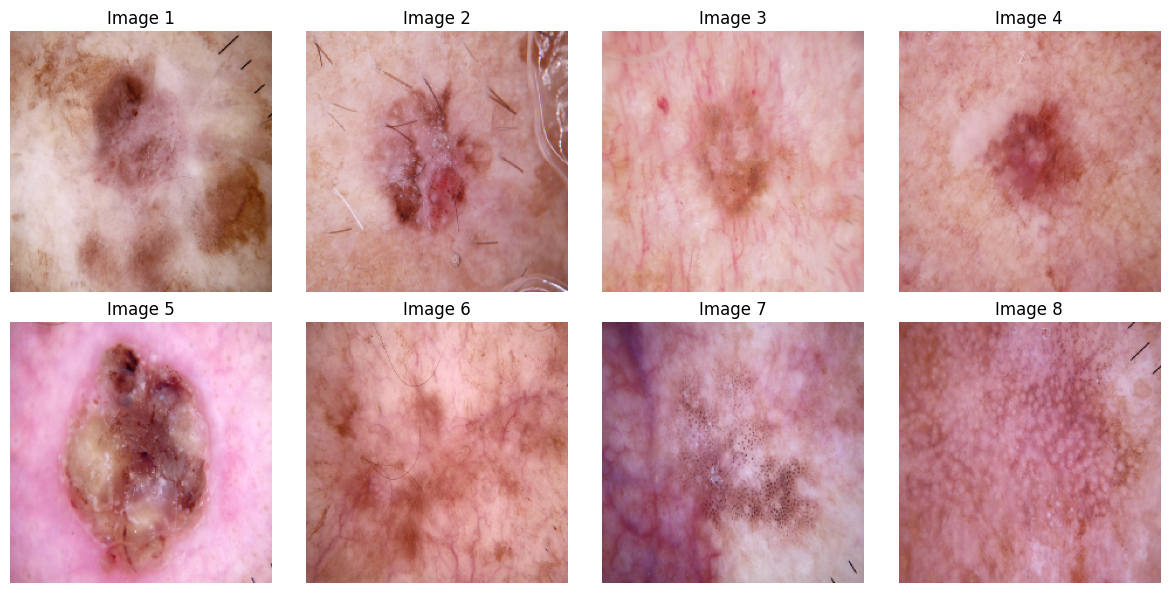

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6)) #creating a 2x4 grid for the images
axes = ax.flatten() #flatten the axes so that they care clearly visible

for i in range(8):
  axes[i].imshow(X_train[i])
  axes[i].axis('off')
  axes[i].set_title(f"Image {i + 1}")

plt.tight_layout()
plt.show()

# Loading Test Images Using the ImageDataGenerator

In [ ]:
batch_size=16
test_datagen = ImageDataGenerator(rescale=1./255)

test_batches = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

X_test_list = []
y_test_list = []

print("test_batches information:", len(test_batches), test_batches.samples)
print("test_batches filepaths:", test_batches.filepaths[:5])  # Print the first 5 file paths
for i in range(len(test_batches)):
  X_batch, y_batch = next(test_batches)
  X_test_list.append(X_batch)
  y_test_list.append(y_batch)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)
y_test_cat = np.concatenate(y_test_list, axis=0)
Y_test_labels = np.argmax(y_test, axis=1)

print("Test set loaded up with {} images".format(X_test.shape[0]))
y_test_cat.shape

Found 1103 images belonging to 7 classes.
test_batches information: 69 1103
test_batches filepaths: ['HAM10000/test/akiec/ISIC_0024511.jpg', 'HAM10000/test/akiec/ISIC_0024707.jpg', 'HAM10000/test/akiec/ISIC_0025358.jpg', 'HAM10000/test/akiec/ISIC_0025803.jpg', 'HAM10000/test/akiec/ISIC_0026014.jpg']
Test set loaded up with 1103 images


(1103, 7)

# Performing Logistic Regression

In [33]:
#Flattening the images with sci-kit learn

x_train_flat = X_train.reshape(X_train.shape[0], -1)
x_test_flat = X_test.reshape(X_test.shape[0], -1)

#Training the model using sci-kit learn
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100, verbose=1, n_jobs=-1)
model.fit(x_train_flat, Y_train)

#Making predictions
y_pred = model.predict(x_test_flat)
##calculating the accuracy of the model
accuracy = accuracy_score(Y_test_labels, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 2225 seconds
Test Accuracy: 0.7099


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Performing Neural Network

In [13]:
model = Sequential([
    Input(shape=(image_size, image_size, 3)),
    Flatten(), #flattens the images so that it is fed to a neural network
    Dense(1024, activation='relu'), #creating the neural network
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(targetNames), activation='softmax')
])

optimizer = Adam(learning_rate=0.002, epsilon=0.1)
model.compile(optimizer=optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'], run_eagerly=True)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,839,431 (590.67 MB)

 Trainable params: 154,839,431 (590.67 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
checkpoint = ModelCheckpoint('T2v.weights.h5', monitor='val_loss', save_weights_only=True,save_best_only=True, mode='min')

history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1, callbacks=[checkpoint])

model.load_weights('T2v.weights.h5')
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test Accuracy {}'.format(test_acc))

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.1939 - loss: 1.9105 - val_accuracy: 0.2620 - val_loss: 1.9968
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.2876 - loss: 1.7983 - val_accuracy: 0.7597 - val_loss: 0.9193
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.2995 - loss: 1.7585 - val_accuracy: 0.6111 - val_loss: 1.3464
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.3356 - loss: 1.6583 - val_accuracy: 0.5539 - val_loss: 1.3222
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.3663 - loss: 1.6017 - val_accuracy: 0.5694 - val_loss: 1.3160
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.4058 - loss: 1.5487 - val_accuracy: 0.4959 - val_loss: 1.5079
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.4375 - loss: 1.4785 - val_accuracy: 0.3898 - val_loss: 1.7101
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.4345 - loss: 1

# Data Augmentation Through CNN

In [15]:
#setting seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

aug_dir = 'aug_dir'
image_size = 224
max_data = 8000

#create output directory if it doesn't exist
os.makedirs(aug_dir, exist_ok=True)

#create label to index mapping
label_to_index = {label: idx for idx, label in enumerate(targetNames)}

#defining data augmentation

datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

for label in targetNames:
  #creating class subfolder in aug_dir
  label_output_dir = os.path.join(aug_dir, label)
  os.makedirs(label_output_dir, exist_ok=True)

  #getting the list of images in the original training folder for this label
  class_dir = os.path.join(train_dir, label)
  file_list = os.listdir(class_dir)


  image_for_class =[]
  for file in file_list:
    image_path = os.path.join(class_dir, file)
    img = load_img(image_path, target_size=(image_size, image_size))
    img_arr = img_to_array(img)
    image_for_class.append(img_arr)

  #Convert list to an array
  X_all = np.array(image_for_class, dtype=np.float32)
  n_images = len(X_all)


  #----------------------------
  # CASE 1: If more than max_data
  #-----------------------------

  if n_images > max_data:
    #randomly sample the images
    selected_indices = np.random.choice(n_images, size=max_data)
    X_selected = X_all[selected_indices]

    #save the randomly selected images to aug_dir
    for i, img_array in enumerate(X_selected):
      out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
      save_img(out_path, img_array)

    print(f"Saved {max_data} images to {label_output_dir}")

  #---------------------------------------
  # CASE 2: If there are less than max_data
  #---------------------------------------

  elif n_images < max_data:
    # Save all existing images first
    for i, img_array in enumerate(X_all):
        out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
        save_img(out_path, img_array)

    # Now we figure out how many augmented images are needed
    needed = max_data - n_images

    # Create a small generator for augmentation
    gen = datagen.flow(X_all, batch_size=1, shuffle=True)

    # Generate and save the augmented images
    for i in range(needed):
        X_aug = next(gen)[0]  #outputs a batch of 1, shape (1, H, W, C)
        out_path = os.path.join(label_output_dir, f'aug_{i}.jpg')
        save_img(out_path, X_aug)

    print(f"Saved {n_images} original + {needed} augmented images for class '{label}' (total {max_data}).")

  #--------------------------------------
  # CASE 3: Exactly max_data
  #--------------------------------------

  else:
    for i, img_array in enumerate(X_all):
      out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
      save_img(out_path, img_array)
    print(f"Exactly {max_data} images for class {label}.")

Saved 121 original + 7879 augmented images for class 'akiec' (total 8000).
Saved 140 original + 7860 augmented images for class 'bcc' (total 8000).
Saved 352 original + 7648 augmented images for class 'bkl' (total 8000).
Saved 31 original + 7969 augmented images for class 'df' (total 8000).
Saved 184 original + 7816 augmented images for class 'mel' (total 8000).
Saved 3532 original + 4468 augmented images for class 'nv' (total 8000).
Saved 51 original + 7949 augmented images for class 'vasc' (total 8000).


# Loading Test Images on the ImageDataGenerator for CNN

In [16]:
batch_size = 16
image_size = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode = 'categorical',
    shuffle=False
)

Found 1103 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


# Constructing CNN

In [18]:
model = Sequential([
    Input(shape=(image_size, image_size, 3)),

    #Block 1
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    #Block 2
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    #Block 3
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    #Classification Block
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(targetNames), activation='relu')

])
opt1 = tf.keras.optimizers.Adam(learning_rate=0.012, epsilon=0.9)
model.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy'])

In the CNN we've constructed, we've created convolutional layers, which are the core building blocks of CNN. Each layer has a pooling window that downsamples the feature maps it has on the image, reducing the need for complexity and dimensionality.
Additionally, In our classification block, we start out by flattening the images so that it feeds to the neural network during training. A fully connected layer with 512 neurons processes these flatten images. Then, we apply the dropout to prevent overfitting during training.

In [19]:
checkpoint = ModelCheckpoint('Best_CNN.weights.h5', monitor='val_accuracy', save_weights_only=True,save_best_only=True, mode='max')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 529ms/step - accuracy: 0.7675 - loss: 3.3813 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 2/50
 1/68 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.7500 - loss: 4.0295

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.7500 - loss: 4.0295 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 209ms/step - accuracy: 0.7880 - loss: 3.4167 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.7500 - loss: 4.0295 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.7858 - loss: 3.4524 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.7500 - loss: 4.0295 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.7990 - loss: 3.2406 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.7500 - loss: 4.0295 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step - accuracy: 0.7969 - loss: 3.2735 - val_accuracy: 0.8097 - 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.8153 - loss: 2.9764 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 48/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.8750 - loss: 2.0148 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 49/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.8091 - loss: 3.0774 - val_accuracy: 0.8097 - val_loss: 3.0666
Epoch 50/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.6875 - loss: 5.0369 - val_accuracy: 0.8097 - val_loss: 3.0666


## Displaying the Accuracy and Loss for This Model

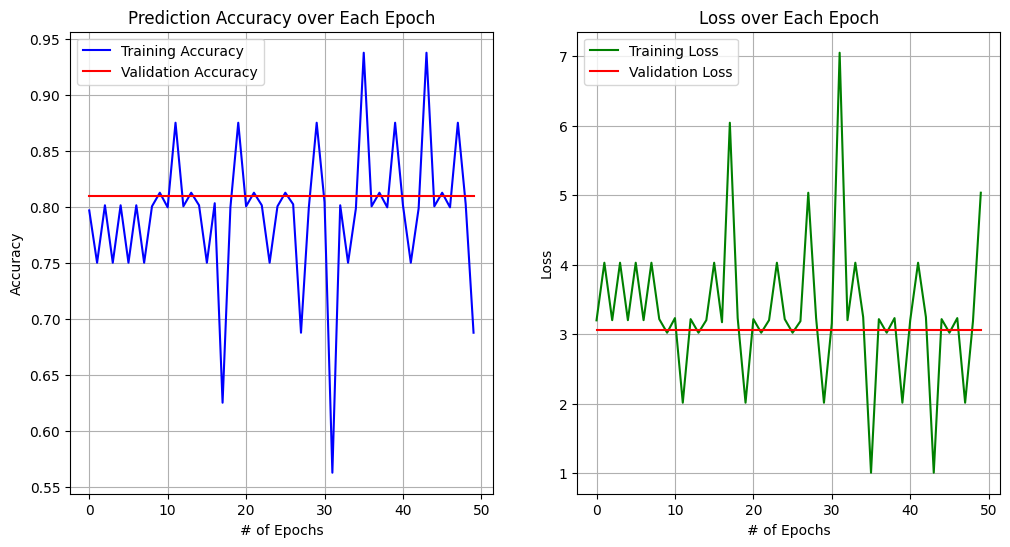

In [20]:

#Displaying the Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Prediction Accuracy over Each Epoch')
plt.grid(True)

#Displaying the Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='green', label='Training Loss')
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Each Epoch')
plt.grid(True)
plt.show()

## Loading The Best Weights and Evaluating the Test Accuracy

In [21]:
#loading the best weights
model.load_weights('Best_CNN.weights.h5')

#Evaluate using the test generator
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print('Test Accuracy: {}'.format(test_acc))

Test Accuracy: 0.8005439639091492


## Exploring the Res-Net 50 Architecture

In [28]:
#Improving the accuracy of the model by applying the advanced ResNet 50 architecure
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


#Loading the ResNet50 base
image_size = 224
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)


#Adding the classifcation head on top of the model's base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(targetNames), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

opt = tf.keras.optimizers.Adam(learning_rate=0.012, epsilon=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [29]:
checkpoint = ModelCheckpoint('Best_R50.weights.h5', monitor='val_accuracy', save_weights_only=True,save_best_only=True, mode='max')

In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint]
)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 100s 643ms/step - accuracy: 0.5575 - loss: 1.4554 - val_accuracy: 0.7969 - val_loss: 1.4477
Epoch 2/50
 1/68 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.7500 - loss: 0.4590

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.7500 - loss: 0.4590 - val_accuracy: 0.8061 - val_loss: 1.3824
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step - accuracy: 0.7927 - loss: 0.5836 - val_accuracy: 0.8097 - val_loss: 1.0506
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8125 - loss: 0.6141 - val_accuracy: 0.8097 - val_loss: 1.0442
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.8437 - loss: 0.4568 - val_accuracy: 0.8097 - val_loss: 1.0872
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.8750 - loss: 0.3100 - val_accuracy: 0.8097 - val_loss: 1.1015
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.8842 - loss: 0.3191 - val_accuracy: 0.8097 - val_loss: 1.0725
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 1.0000 - loss: 0.1193 - val_accuracy: 0.8097 - val_loss: 1.0664
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.9134 - loss: 0.2446 - val_accuracy: 0.8097 - 

In [31]:
model.load_weights('Best_R50.weights.h5')
#Evaluating the model using the test generator
test_loss, test_acc = model.evaluate(test_generator,steps=test_generator.samples // batch_size, verbose=0)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9715


## Displaying The Loss and Accuracy After Applying the ResNet-50

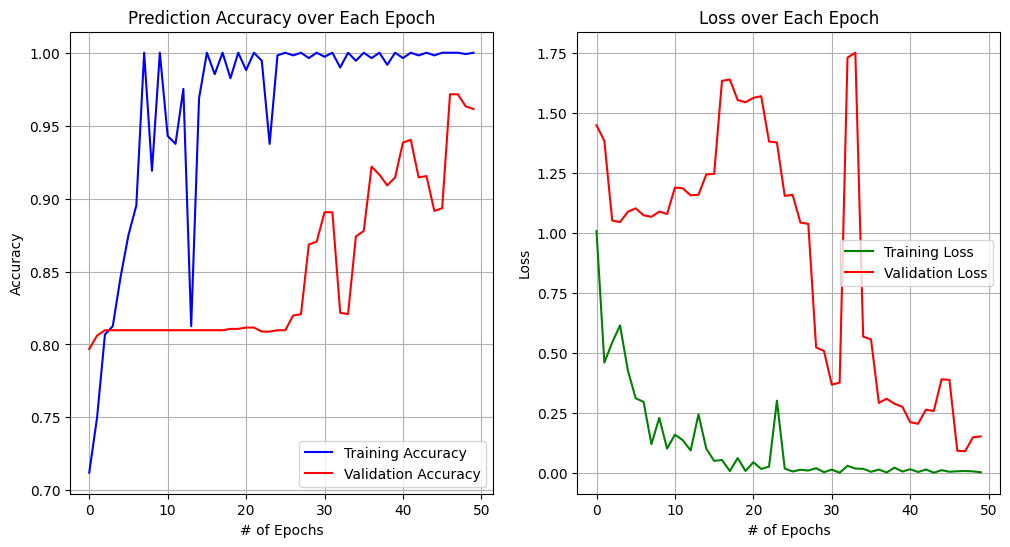

In [32]:
#Displaying the accuracy of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Prediction Accuracy over Each Epoch')
plt.grid(True)

#Displaying the Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='green', label='Training Loss')
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Each Epoch')
plt.grid(True)
plt.show()


As you can see based on two depictions on the relationship between the accuracy and the loss, you can see that the accuracy has surged between 90 and 100%. This allows for greater improvement in the model for classifying whether the image displayed is either benign or malignant of skin cancer. On the right, we have the loss over the number of epochs during training. We find that the loss is exponentially decreasing over the number of epochs.